# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части. 

In [5]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [6]:
words = Counter()

for example in dataset['train']['text']:
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

Размер словаря: 11842


In [7]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ] 
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])
    
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [8]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(69)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 64
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [9]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])
    
    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Запуск базовой модели с семинара на новом датасете (1 балл)

In [10]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [11]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc
    # Добавим выход лосса каждую и эпоху и также accuracy(evaluate) после обучения модели
    print(f'Базовая модель (aggregation_type = {aggregation_type}) accuracy :{evaluate(model, eval_dataloader)}')

Starting training for max
Базовая модель (aggregation_type = max) accuracy :0.9007999897003174
Starting training for mean
Базовая модель (aggregation_type = mean) accuracy :0.9097999930381775


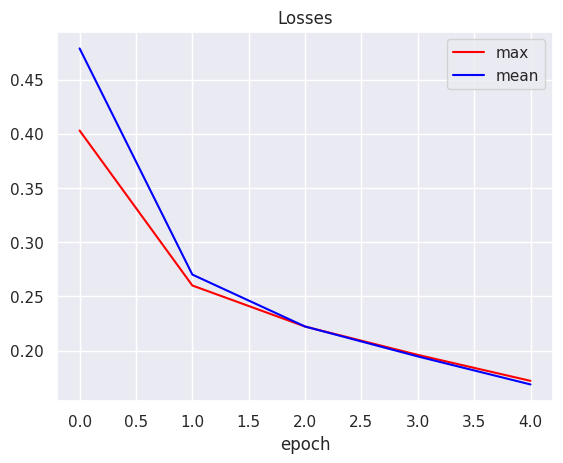

In [12]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.92
Лучшая accuracy для подхода mean: 91.24


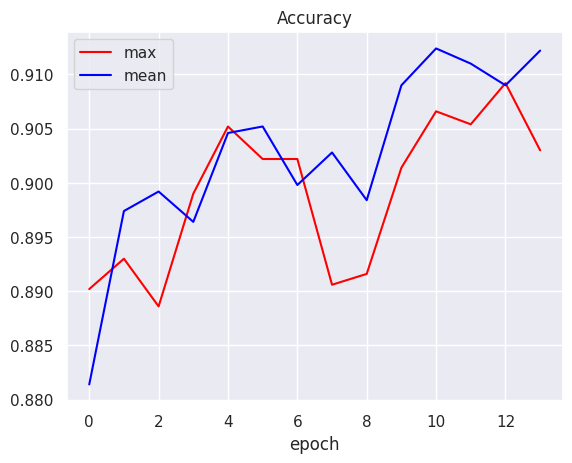

In [13]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)

**Эксперимент №1**

Давайте воспользуемся нейросетевой моделью LSTM.

In [14]:
class CharLM_LSTM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        num_layers: int=2, aggregation_type: str = 'max'
        ):
        super(CharLM_LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.LSTM = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.LSTM(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [15]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM_LSTM(
        hidden_dim=256,num_layers=2, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc
    print(f'Эксперимент 1 (aggregation_type = {aggregation_type}) accuracy :{evaluate(model, eval_dataloader)}')

Starting training for max
Эксперимент 1 (aggregation_type = max) accuracy :0.9073999524116516
Starting training for mean
Эксперимент 1 (aggregation_type = mean) accuracy :0.9043999910354614


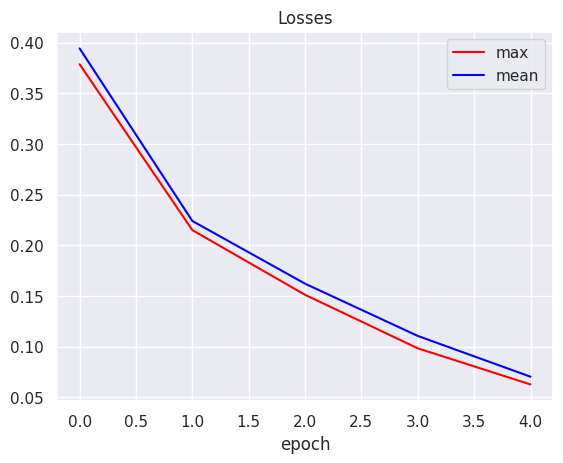

In [16]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.68
Лучшая accuracy для подхода mean: 91.96


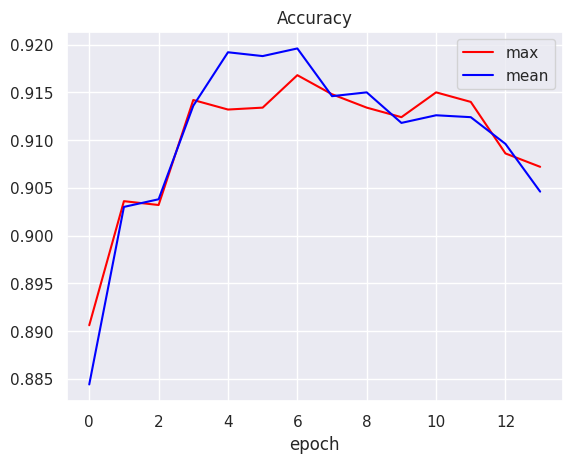

In [17]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

**Эксперимент №2**

Подбор гиперпараметров , увеличим:
* vocab с 11842 до 19562
* LSTM слои до 4
* hidden_dim до 512

In [18]:
# для начала увеличим размер словаря
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 10

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

Размер словаря: 19562


In [19]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM_LSTM(
        hidden_dim=512,num_layers=4, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc
    print(f'Эксперимент 2 (aggregation_type = {aggregation_type}) accuracy :{evaluate(model, eval_dataloader)}')

Starting training for max
Эксперимент 2 (aggregation_type = max) accuracy :0.91239994764328
Starting training for mean
Эксперимент 2 (aggregation_type = mean) accuracy :0.9109999537467957


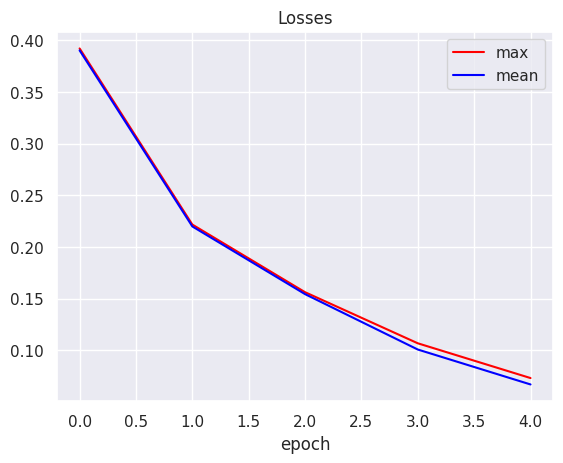

In [20]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.60
Лучшая accuracy для подхода mean: 92.14


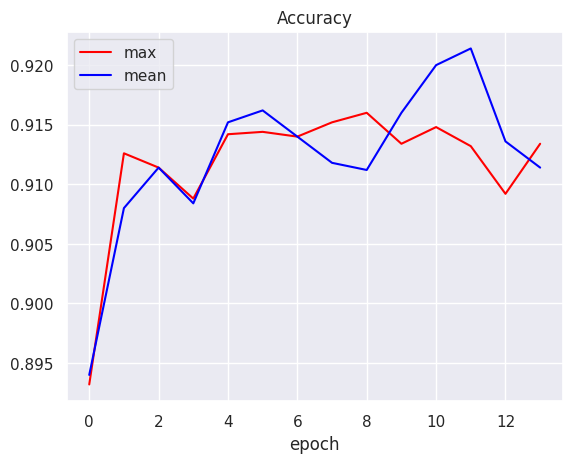

In [21]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

**Вывод**:
1. *Базовая модель*-
    Модель и гиперпараметры использовались из семинара, 5 эпох, как видно по графикам лосс у обеих методово агрегации еще не вышел на плато, но у подхода "max" лосс чуть меньше и  accuracy чуть выше.
 
Базовая модель (aggregation_type = max) accuracy :0.8971

Базовая модель (aggregation_type = mean) accuracy :0.9065

2. *Эксперимент 1* - по сути базовая модель, только вместо класического rnn использовалось 2 слоя LSTM. Картина с лосом у подхода "max" такая же как у базовой модели, но вот accuracy упал и 'mean' оказался выше по значению. Самый лучший accuracy ~0.915

Эксперимент 1 (aggregation_type = max) accuracy :0.9147

Эксперимент 1 (aggregation_type = mean) accuracy :0.9111

3. *Эксперимент 2* - модель из предыдущего эксперимента, но мы добавили больше слов в словарь для обучения, увеличели значение скрытых и LSTM слоев в 2 раза. 

Эксперимент 2 (aggregation_type = max) accuracy :0.9129

Эксперимент 2 (aggregation_type = mean) accuracy :0.9057

Метод evalute для подсчета accuracy был внедрен в train loop, для удобства.

Модели были обучены по 10 и 15 эпох, но accuracy начинал падать, возможно модель расходилась и соответственно шло переобучение.